In [2]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [3]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
sagemaker_session = sagemaker.Session()


In [5]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-electricity-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [6]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [7]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [8]:
# Extract

DATA_HOST = "sagemaker-sample-files"
DATA_PATH = "datasets/timeseries/uci_electricity/"
ARCHIVE_NAME = "LD2011_2014.txt.zip"
FILE_NAME = ARCHIVE_NAME[:-4]

In [9]:
s3_client = boto3.client("s3")

if not os.path.isfile(FILE_NAME):
    print("downloading dataset (258MB), can take a few minutes depending on your connection")
    s3_client.download_file(DATA_HOST, DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME)

    print("\nextracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, "r")
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found skipping download")

downloading dataset (258MB), can take a few minutes depending on your connection

extracting data archive


In [10]:
# Transform

data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=",")
num_timeseries = data.shape[1]
data_kw = data.resample("2H").sum() / 8
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:, i], trim="f"))

In [11]:
print(data.head)

<bound method NDFrame.head of                        MT_001     MT_002    MT_003      MT_004     MT_005  \
2011-01-01 00:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:30:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:45:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
...                       ...        ...       ...         ...        ...   
2014-12-31 23:00:00  2.538071  22.048364  1.737619  150.406504  85.365854   
2014-12-31 23:15:00  2.538071  21.337127  1.737619  166.666667  81.707317   
2014-12-31 23:30:00  2.538071  20.625889  1.737619  162.601626  82.926829   
2014-12-31 23:45:00  1.269036  21.337127  1.737619  166.666667  85.365854   
2015-01-01 00:00:00  2.538071  19.914651  1.737619  178.861789  84.146341   

                         MT_006     MT_007   

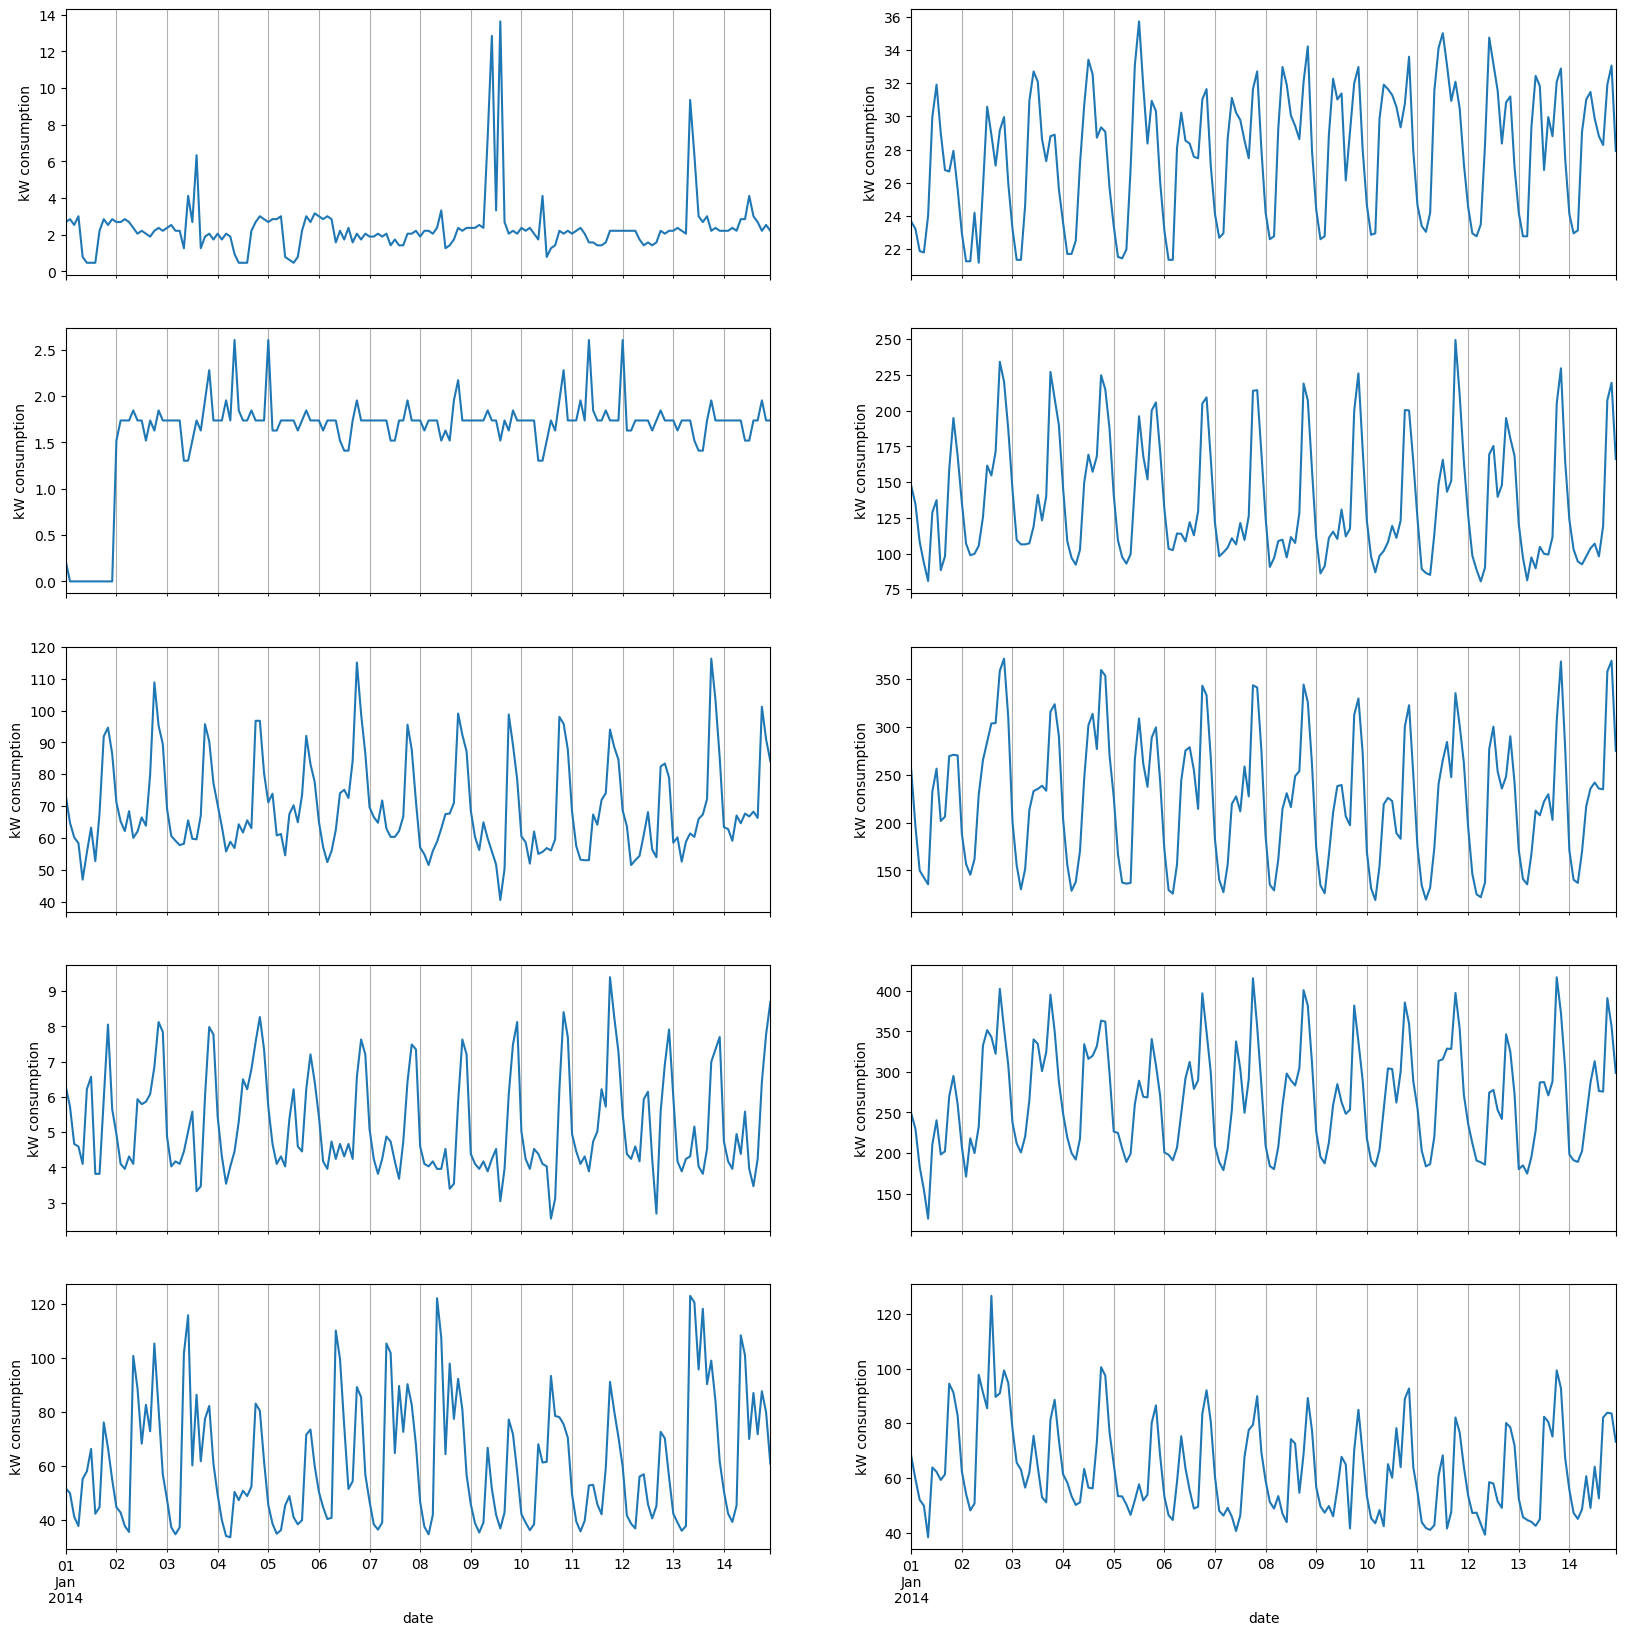

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("kW consumption")
    axx[i].grid(which="minor", axis="x")


In [13]:
# Train Test Split

# we use 2 hour frequency for the time series
freq = "2H"

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12


In [14]:
start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  


In [15]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

370


In [16]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

1480


In [17]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [18]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 6.44 s, sys: 222 ms, total: 6.66 s
Wall time: 7.97 s


In [19]:
# Load

s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [20]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-376650895514/deepar-electricity-demo-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-376650895514/deepar-electricity-demo-notebook/data/test/test.json
CPU times: user 458 ms, sys: 231 ms, total: 689 ms
Wall time: 1.58 s


In [21]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2014-01-01 00:00:00", "target": [2.696700507614215, 2.85532994923858, 2.53807106598985, 3...


In [23]:
# Train the Model

estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    base_job_name="deepar-electricity-demo",
    output_path=s3_output_path,
)

In [24]:
# default hyperparameters

hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [25]:
estimator.set_hyperparameters(**hyperparameters)

In [26]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

2023-01-29 18:25:43 Starting - Starting the training job...
2023-01-29 18:26:07 Starting - Preparing the instances for trainingProfilerReport-1675016743: InProgress
......
2023-01-29 18:27:11 Downloading - Downloading input data...
2023-01-29 18:27:31 Training - Downloading the training image......
2023-01-29 18:28:27 Training - Training image download completed. Training in progress.Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[01/29/2023 18:28:38 INFO 140052358952768] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.js

In [27]:
# Create Endpoint

from sagemaker.serializers import IdentitySerializer

In [28]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [29]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

------!

In [30]:
predictor.predict(ts=timeseries[120], quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2015-01-01 02:00:00,144.336945,157.540497,169.713196
2015-01-01 04:00:00,164.367706,178.370743,191.822067
2015-01-01 06:00:00,198.660217,213.780502,233.399307
2015-01-01 08:00:00,308.560486,332.658844,356.916718
2015-01-01 10:00:00,305.586914,337.942322,358.836365


In [31]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=end_training,
    show_samples=False,
    plot_history=7 * 12,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        "calling served model to generate predictions starting from {}".format(str(forecast_date))
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1, 1, 1)

    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # plot the target
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    target_section.plot(color="black", label="target")

    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")

In [32]:
style = {"description_width": "initial"}

In [33]:
@interact_manual(
    customer_id=IntSlider(min=0, max=369, value=91, style=style),
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False,
)
def plot_interact(customer_id, forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence,
    )

interactive(children=(IntSlider(value=91, description='customer_id', max=369, style=SliderStyle(description_wi…